# Customer Churn Prediction with IBM Db2 Warehouse using PySpark

# Part 1 : Data exploration

__Introduction__

This notebook presents a churn prediction use case using anonymized customer data from a phone operator. It uses IBM Db2 Warehouse and runs on a PySpark kernel. It is the first part of a series on this use case. It is focused on data exploration and visualization. The goal is to gain some insights for feature selection. Visualizations are plotted locally using seaborn and matplotlib whereas data is manipulated using PySpark.

__Use case__

Our goal is to accurately predict whether a customer is going to end his/her contract (labeled as positive,1). We prefer to send a commercial email to someone who intends to keep her contract but is labeled as willing to end it (false positive) rather than to overlook the opportunity of preventing a customer from ending her contract (false negative). We also care to accurately target customers with engagement campaigns : not overwhelming customers with commercials and not losing money by proposing special offers to too many people (precision and accuracy). Our optimization objective will thus consist in maximizing recall i.e minimizing the false negative rate. We will also look at a couple of other indicators such as accuracy and area under curve (see part 2 of this series).


__Contents__
1. Get ready
2. Explore the data
3. Prepare the data

## 1. Get ready

__Imports__

Import the necessary PySpark classes, as well as Python packages for local visualisations.
We will plot the graphs directly in this notebook. If you like to plot them in a separate window, just comment out `%matplotlib inline`.

In [1]:
# Useful imports - PySpark

from pyspark.sql import SparkSession

from pyspark.ml.linalg import Vectors
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import MinMaxScaler

import numpy as np

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
207,None,pyspark,idle,,,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
%local
%matplotlib inline

# Useful imports for local visualisations

import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import numpy as np
import seaborn as sns

__Load the data__

Let's use one of the Db2 Warehouse sample tables. It is called SAMPLES.TRAINING. 

In [3]:
sparkSession = SparkSession \
        .builder \
        .getOrCreate()

df = sparkSession.read \
        .format("com.ibm.idax.spark.idaxsource") \
        .options(dbtable="SAMPLES.TRAINING") \
        .load()
df.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+----+-----+----------+--------+---------+----------+--------+---------+----------+----------+-----------+------------+---------+----------+-----------+---------+
|CHURN|AREA|VMAIL|VMAIL_MSGS|DAY_MINS|DAY_CALLS|DAY_CHARGE|EVE_MINS|EVE_CALLS|EVE_CHARGE|NIGHT_MINS|NIGHT_CALLS|NIGHT_CHARGE|INTL_MINS|INTL_CALLS|INTL_CHARGE|SVC_CALLS|
+-----+----+-----+----------+--------+---------+----------+--------+---------+----------+----------+-----------+------------+---------+----------+-----------+---------+
|    0| 415|    1|         0|   147.7|       94|     25.11|   283.3|       83|     24.08|     188.3|        124|        8.47|      6.9|         5|       1.86|        2|
|    0| 408|    1|         0|   229.9|      130|     39.08|   144.4|       93|     12.27|     262.4|        110|       11.81|     14.2|         4|       3.83|        2|
|    0| 408|    1|         0|   102.8|      128|     17.48|   143.7|       95|     12.21|     191.4|         97|        8.61|     10.0|         5|       2.

Quick look-up : How many records do we have? How many features?

In [4]:
print('Number of records: '+str(df.count()))
print('Number of features: '+str(len(df.columns)))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Number of records: 3333
Number of features: 17

## 2. Explore the data

__Data schema__

In [5]:
df.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- CHURN: short (nullable = false)
 |-- AREA: integer (nullable = false)
 |-- VMAIL: short (nullable = false)
 |-- VMAIL_MSGS: integer (nullable = false)
 |-- DAY_MINS: decimal(5,1) (nullable = false)
 |-- DAY_CALLS: integer (nullable = false)
 |-- DAY_CHARGE: decimal(5,2) (nullable = false)
 |-- EVE_MINS: decimal(5,1) (nullable = false)
 |-- EVE_CALLS: integer (nullable = false)
 |-- EVE_CHARGE: decimal(5,2) (nullable = false)
 |-- NIGHT_MINS: decimal(5,1) (nullable = false)
 |-- NIGHT_CALLS: integer (nullable = false)
 |-- NIGHT_CHARGE: decimal(5,2) (nullable = false)
 |-- INTL_MINS: decimal(4,1) (nullable = false)
 |-- INTL_CALLS: integer (nullable = false)
 |-- INTL_CHARGE: decimal(4,2) (nullable = false)
 |-- SVC_CALLS: integer (nullable = false)

Columns include:

- Churn : whether the customer resigned his/her phone subscription, this is our target
- Area : a geographic label, we might wonder which impact this feature has on churn
- VMail: whether voice messages have been left (1 means no message)
- VMail_msgs: number of voice messages
- day_mins, eve_mins, night_mins, intl_mins: time spend calling in the day/evening/night/abroad __TB: "time spent"__
- day_calls, eve_calls, night_calls, intl_calls: number of calls in each category
- day_charge, eve_charge, night_charge, intl_charge: price charged for each category
- svc_calls: service calls.

__A few statistics__

In [6]:
df.describe().toPandas().transpose()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                  0                    1                    2     3      4
summary       count                 mean               stddev   min    max
CHURN          3333  0.14491449144914492  0.35206742362412613     0      1
AREA           3333   437.18241824182417    42.37129048560659   408    510
VMAIL          3333   0.7233723372337234  0.44739787038006396     0      1
VMAIL_MSGS     3333    8.099009900990099   13.688365372038604     0     51
DAY_MINS       3333            179.77510   54.467389202371336   0.0  350.8
DAY_CALLS      3333   100.43564356435644   20.069084207300882     0    165
DAY_CHARGE     3333            30.562307    9.259434553930504  0.00  59.64
EVE_MINS       3333            200.98035    50.71384442581198   0.0  363.7
EVE_CALLS      3333   100.11431143114311    19.92262529394308     0    170
EVE_CHARGE     3333            17.083540    4.310667643110341  0.00  30.91
NIGHT_MINS     3333            200.87204   50.573847013658366  23.2  395.0
NIGHT_CALLS    3333   100

We see that there is no missing value in the dataset, which is great: no cleaning needed so far. 

We have a churn rate of roughly 15%, so it should be easy to obtain 85% accuracy. 85% would be the accuracy of a naive classifier which labels all examples as 0 id est customer remains a client. On the contrary, since we have a skewed dataset, predicting true positives will be a harder task (high recall).

__Visualization__

Let's answer the following questions thanks to visualizations: What relationships do exist between features? How are features correlated to churn? What is the average price per minute? Are there outliers? How do feature distributions look like?

* Pull data locally for visualization

Note: our dataset is small so local visualization may be performed without sampling. In practice, with big data sets, you can take a random sample of data for visualization.

First we create a temporary view of our Spark dataframe. Then we query it in an %%sql cell. Finally it is available locally as a Pandas dataframe and can be plotted conveniently. 

In [7]:
df.createOrReplaceTempView('dataset')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
%%sql -o dataset --maxrows -1
SELECT * FROM dataset

__Explore relationships between features with a scatter plot__


1. Distribution of each feature according to the label
2. Pairplots between all features

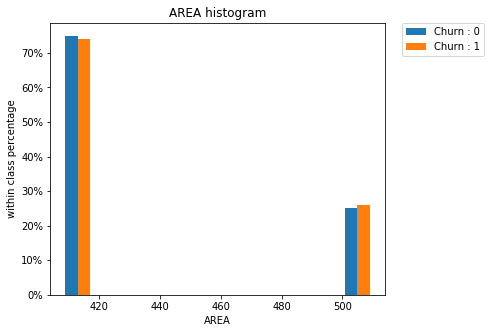

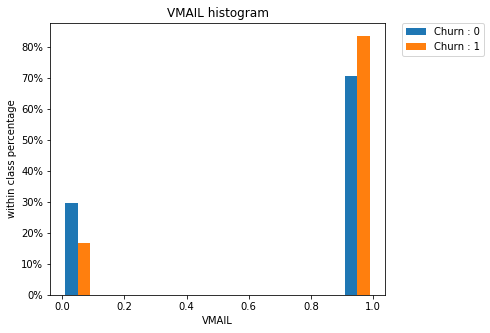

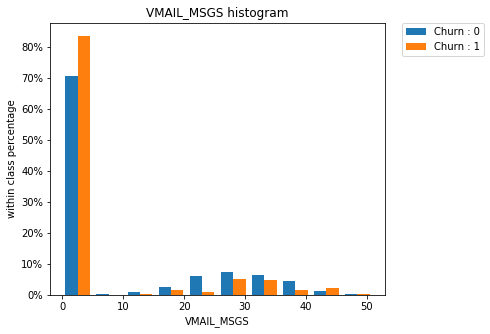

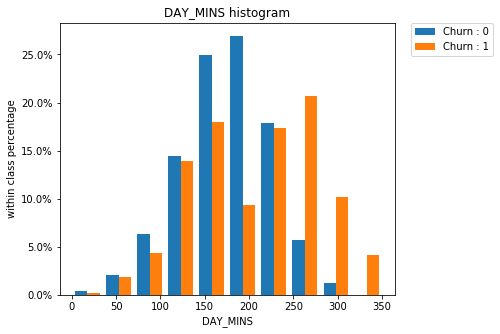

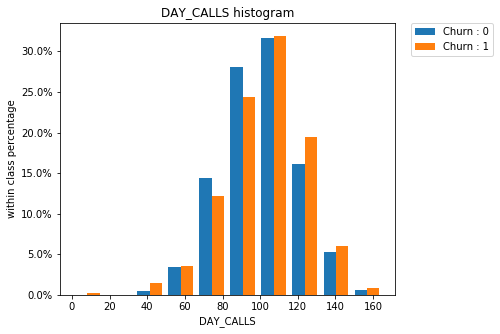

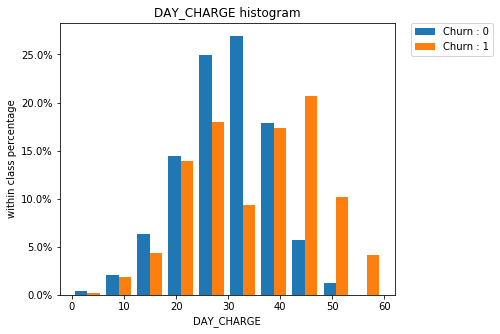

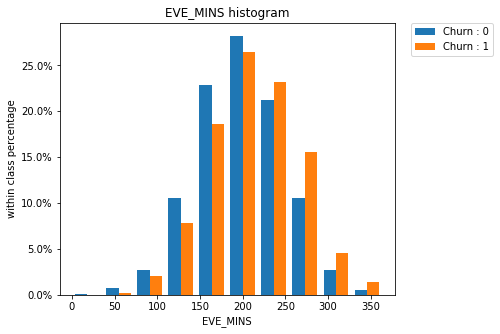

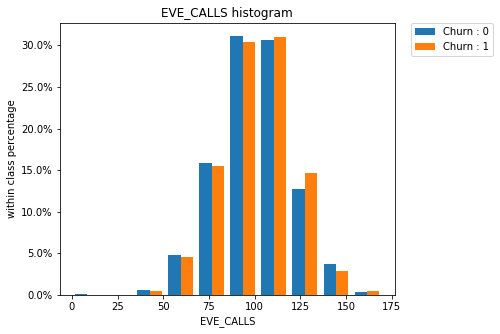

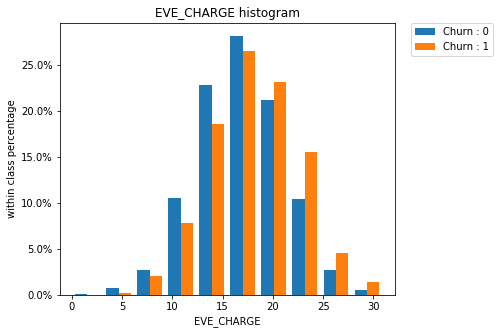

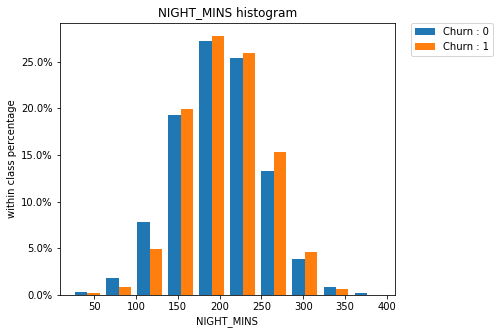

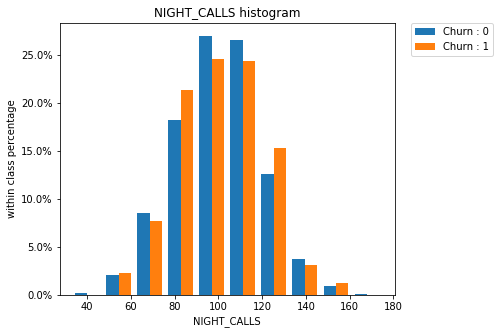

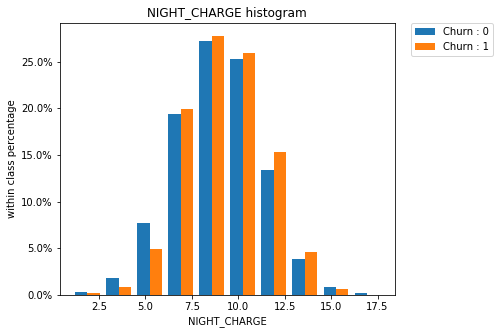

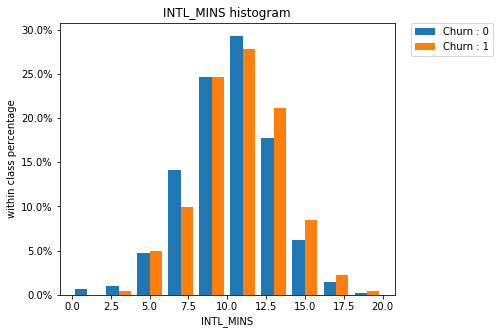

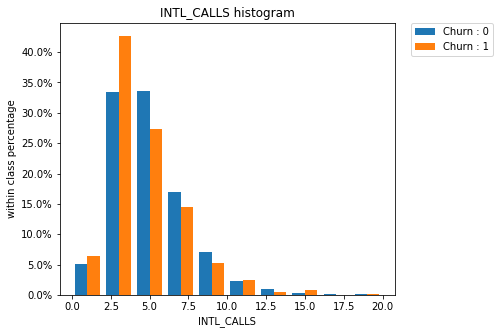

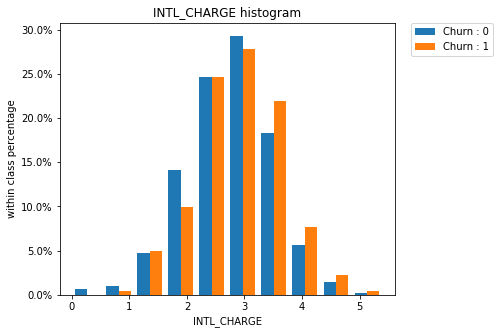

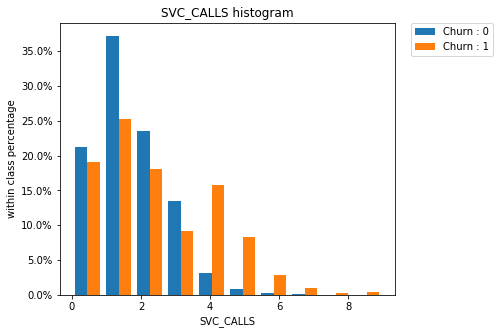

In [9]:
%local

def hist(nameX, bins=None):
    """
    prerequisites : matplotlib.pyplot as plt; dataset stored under this name
    input : nameX is the name of the feature to be plot on the x-axis                
    nameY is the same for the y-axis. They are strings.
    output : plot (x,y) with color code churn, y-axis shows within-class percentage (not number of occurences)
    """
    x0 = dataset[dataset.CHURN == 0][nameX]
    x1 = dataset[dataset.CHURN == 1][nameX]
    
    fig, ax = plt.subplots(figsize=(6,5))
    plt.hist([x0, x1], bins=bins, label = ["Churn : 0", "Churn : 1"], weights=[np.ones(len(x0))/len(x0), np.ones(len(x1))/len(x1)])

    plt.xlabel(nameX)
    plt.ylabel("within class percentage")

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    #plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left', ncol=2, mode="expand", borderaxespad=0.)
    plt.title(nameX + " histogram") 
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    plt.show()

col = list(dataset.columns)

for i in range(1, len(col)):
    hist(col[i])

Comments

* Area : only two distinct areas, distribution does not differ much among classes;
* Voice mail : a higher proportion of churners do not have the voice mail option (vmail = 1), so that there is a higher proportion of churners with Vmail_msgs=0. However, when they do have the voice mail option, churners tend to receive more messages;
* Distribution of minutes spent on the phone differs mostly in the day, whereas habits are quite siilar in the evening and the night;
* Churners have made more service calls than the others : for example, 30% of churners have made more than 4 service calls whereas less than 5% of the non-churners do.

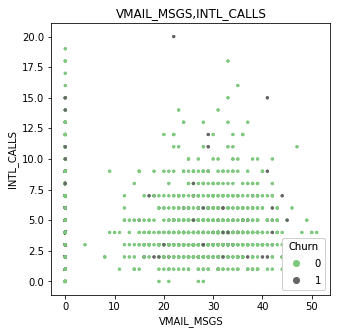

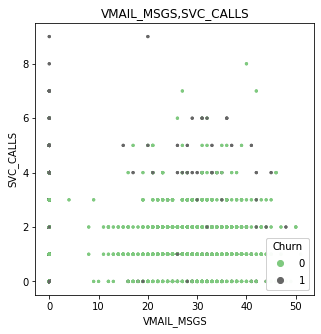

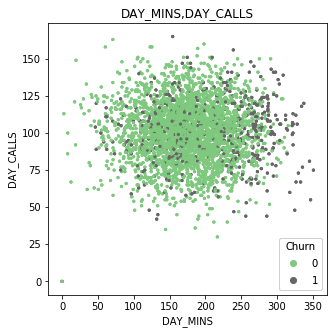

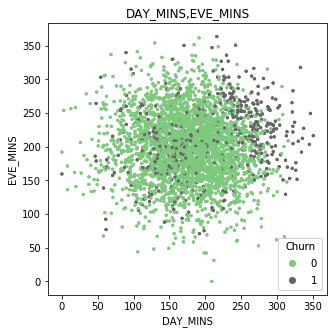

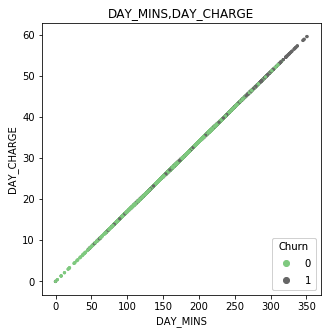

In [10]:
%local

def plot(nameX, nameY, cmap='Accent'):
    """
    prerequisites : matplotlib.pyplot as plt; dataset stored under this name
    input : nameX is the name of the feature to be plot on the x-axis
    nameY is the same for the y-axis. They are strings.
    output : plot (x,y) with color code churn
    """
    x = dataset[nameX]
    y = dataset[nameY]
    c = dataset['CHURN']
    
    fig, ax = plt.subplots(figsize=(5,5))
    scatter = ax.scatter(x, y, c=c, s=5, cmap=cmap)
    scatter = ax.scatter(x, y, c=c, s=5, cmap=cmap)

    # produce a legend with the unique colors from the scatter
    legend1 = ax.legend(*scatter.legend_elements(),
                        loc="lower right", title="Churn")
    ax.add_artist(legend1)

    plt.xlabel(nameX)
    plt.ylabel(nameY)

    plt.title(nameX + "," + nameY) 
    plt.show()

# if you want to display everything :
#for i in range(1,len(col)):
    #for j in range(i+1, len(col)):
        #plot(col[i], col[j])

# Display just a few graphs
plot("VMAIL_MSGS", "INTL_CALLS")
plot("VMAIL_MSGS", "SVC_CALLS")
plot("DAY_MINS", "DAY_CALLS")
plot("DAY_MINS", "EVE_MINS")
plot("DAY_MINS", "DAY_CHARGE")

Comments 
- Clusters tend to appear but the brown zone is superimposed with the green underlying zone, which indicates a low separabiliy of the classes in these projection dimensions, so this might make prediction hard (example : night_charge over intl_charge);
- pricing seems to be linear (example: day_charge over day_mins, simple linear function between time and price, no flat rate or minimum charge).

__Find out the price per minute with a linear regression__

In the previous section we could see that a linear function seems to map the time spent on the phone to the price actually charged. To confirm this intuition, let's perform a linear regression in order to compute the average price per minute. We take the example of phone calls made during day time, the same method can be applied to the other categories. But first, let's compare prices between categories.

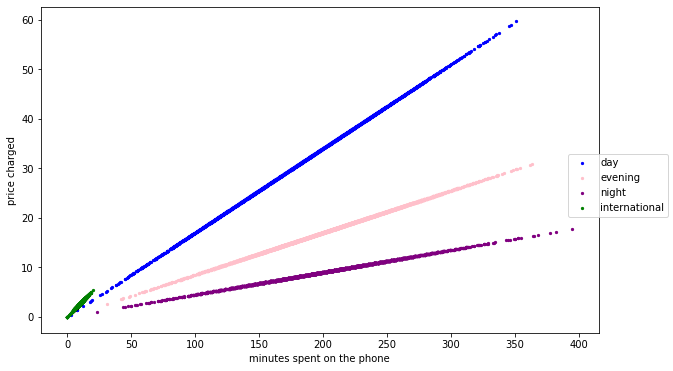

In [11]:
%local

# Price charged per minute - category comparison

ax, fig=plt.subplots(figsize=(10,6))

plt.scatter(dataset['DAY_MINS'], dataset['DAY_CHARGE'], color='blue', s=5, label='day')
plt.scatter(dataset['EVE_MINS'], dataset['EVE_CHARGE'], color='pink', s=5, label='evening')
plt.scatter(dataset['NIGHT_MINS'], dataset['NIGHT_CHARGE'], color='purple', s=5, label='night')
plt.scatter(dataset['INTL_MINS'], dataset['INTL_CHARGE'], color='green', s=5, label='international')


plt.xlabel('minutes spent on the phone')
plt.ylabel('price charged')

ax.legend(loc='right')

plt.show()

International calls are more expensive. A higher price is charged during the day than during the evening and the night. It seems that for each call type, a linear pricing is applied. Let's confirm this intuition by building a linear regression model.

First, be have to prepare the data so that it is in the format [feature, label] required by the dedicated PySpark functions.

In [12]:
# Data preparation

#Select necessary features DAY_MINS (input feature) and DAY_CHARGE (target feature or label)
data_DAY = df.select(df.DAY_MINS, df.DAY_CHARGE)

# Define the vector assembler you need for this linear regression
DAY_assembler = VectorAssembler().setInputCols(['DAY_MINS',]).setOutputCol('features')

# Transform the datasets according to this assembler
data01 = DAY_assembler.transform(data_DAY)

# Rename the DAY_CHARGE column to label and select omly the label and features column
data02 = data01.select(data01["features"], data01["DAY_CHARGE"].alias("label"))
#data02.show(5, truncate=False)

# we need to have the keywords features, label and prediction as column names

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Define the model characteristics and fit the model to your training set.

In [13]:
lr = LinearRegression(featuresCol="features", labelCol="label",maxIter=10, regParam=0.3, elasticNetParam=0.8)
LRmodel = lr.fit(data02)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Compute training error: Regression coefficient R2 and RMSE

In [14]:
evaluator = RegressionEvaluator()
data03 = LRmodel.transform(data02)
print("R^2: %f" % evaluator.evaluate(data03,{evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(data03,{evaluator.metricName: "rmse"}))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

R^2: 0.998963
RMSE: 0.298082

R is the regression coefficient. R² value ~ 1 is a good fit. 
The Root Mean Square Error (RMSE) has to be compared to the actual magnitude of the phenomenon. In our case, it is low compared to the mean DAY_CHARGE value (30.56) and its standard deviation (9.24).

This confirm the impression we got from visualization. From now on we can assume that a linear function maps day_mins to day_charge. It's the same for the other categories. We shall then use only the "charge" columns in the next steps of our analysis.

__Customer churn and phoning habits__

Let's see if we can spot some patterns in the data with a scatter plot showing the total number of minutes spent on the phone.

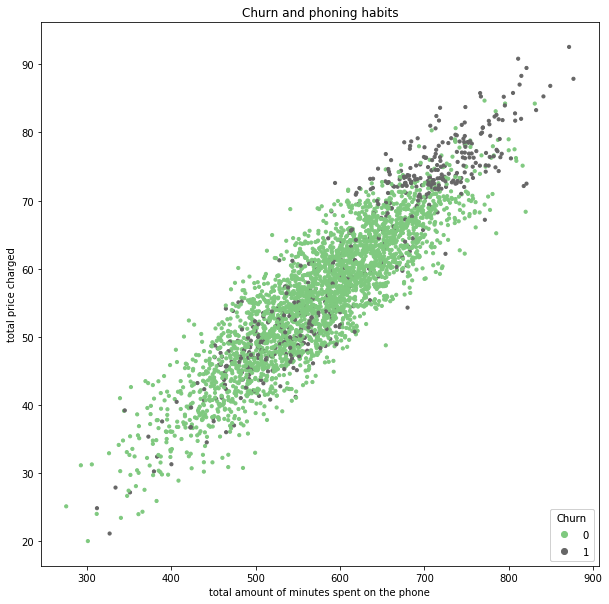

In [15]:
%local

#total amount of time spent on the phone
tot_mins=dataset['DAY_MINS']+dataset['EVE_MINS']+dataset['NIGHT_MINS']

#total price charged
tot_charge=dataset['DAY_CHARGE']+dataset['EVE_CHARGE']+dataset['NIGHT_CHARGE']


# Plot

x, y = tot_mins, tot_charge
c = dataset['CHURN']

fig, ax = plt.subplots(figsize=(10,10))

scatter = ax.scatter(x, y, c=c, s=10, cmap='Accent')

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower right", title="Churn")
ax.add_artist(legend1)

plt.xlabel('total amount of minutes spent on the phone')
plt.ylabel('total price charged')

plt.title('Churn and phoning habits')
plt.savefig('churn')
plt.show()

There seem to be a cluster of people who ended their contract and used the service more than others. People who resigned their contract tend to be charged more than others because they have a high consumption, or to have a middle/low range consumption... which does not allow us to tell them apart from the others for now. There could be two customer clusters as drawn here:

<img src="churn_clusters.png"/>

__Correlation matrix__

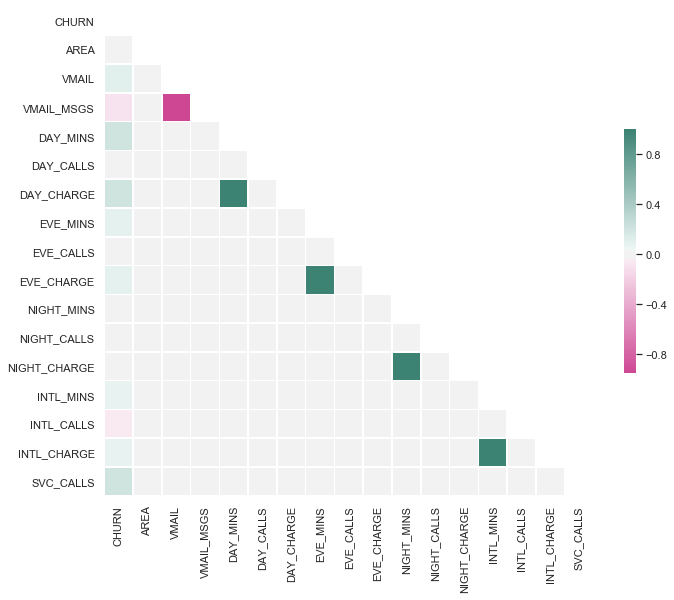

In [16]:
%local

sns.set(style="white")

# Compute the correlation matrix
corr = dataset.corr()

# Generate a mask for the upper triangle
# Since the matrix is symmetric, we just need one half of the coefficients
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(-20, 170, n=10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
#sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})


Features tend not to be very correlated! 

A positive correlation between two features means that the two phenomenons tend to grow together.

Here are the factors that seem to encourage a customer to end his/her contract:

Particularly:
* time spent on the phone in the day
* service calls

And then:
* time spent on international calls
* having no voice mail message

Factors that encourage a customer not to end a contract:
* number of voice mail messages received
* number of international calls made.

Additionaly, we can again observe the linear relation we had alreay discovered between time spent on the phone and price charged. It appears here on the correlation matrix for each type of call. We will therefore delete redundant columns in the next steps of this notebook.

## 3. Prepare the data

__Create new columns__

Here we create a new column. Feel free to come up with new feature combinations and transformations.

In [17]:
# 4 new features
TOT_MINS = df['DAY_MINS']+df['EVE_MINS']+df['INTL_MINS']+df['NIGHT_MINS']
DAY_MINS_perCALL = df['DAY_MINS']/df['DAY_CALLS']
NIGHT_MINS_perCALL = df['NIGHT_MINS']/df['NIGHT_CALLS']
EVE_MINS_perCALL = df['EVE_MINS']/df['EVE_CALLS']
# type <class 'pyspark.sql.column.Column'>

# Add the columns to the existing ones in a new dataframe
tot_df = df.withColumn("TOT_MINS", TOT_MINS).withColumn("DAY_MINS_perCALL", DAY_MINS_perCALL).withColumn("NIGHT_MINS_perCALL", NIGHT_MINS_perCALL).withColumn("EVE_MINS_perCALL", EVE_MINS_perCALL)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Take a look at the new features' statistics.

In [18]:
tot_df.describe().toPandas().transpose()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                        0                    1  ...               3                4
summary             count                 mean  ...             min              max
CHURN                3333  0.14491449144914492  ...               0                1
AREA                 3333   437.18241824182417  ...             408              510
VMAIL                3333   0.7233723372337234  ...               0                1
VMAIL_MSGS           3333    8.099009900990099  ...               0               51
DAY_MINS             3333            179.77510  ...             0.0            350.8
DAY_CALLS            3333   100.43564356435644  ...               0              165
DAY_CHARGE           3333            30.562307  ...            0.00            59.64
EVE_MINS             3333            200.98035  ...             0.0            363.7
EVE_CALLS            3333   100.11431143114311  ...               0              170
EVE_CHARGE           3333            17.083540  ...            0.

Here we notice that there are a few missing values in the new columns, due to divisions by zero. Let's replace the null values with zeros.

In [19]:
df_filled = tot_df.fillna(0)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

__Split the data__

We split the data into three distinct sets: for training, validation and testing. We use the proportions 70%, 15% and 15% so that we keep a relatively high number of examples for training. Of course these proportions are subjective, you can change them if you want. We have defined a seed so that results can be reproduced : the same splits are made in the other notebooks.

In [20]:
train, val, test = df_filled.randomSplit([0.70,0.15,0.15],1)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

__Feature scaling__

Let's scale our features with a MinMax transformation. This is useful in so far as we have features on very different scales and will use a KMeans algorithm in the future.

First we assemble columns into a "features" list because this is  the format required by most PySpark ML functions we will use in the following steps.
We do not use the `_MINS`features because thay are redundant with the `_CHARGE` features and do not scale the categorical features VMAIL and AREA, as well as the label CHURN. Hence the following inputCols list.

In [21]:
assembler = VectorAssembler(
    inputCols=["TOT_MINS", "DAY_MINS_perCALL", "EVE_MINS_perCALL", "NIGHT_MINS_perCALL", "VMAIL_MSGS", "INTL_CALLS", "DAY_CALLS", "EVE_CALLS", "NIGHT_CALLS", "SVC_CALLS", "INTL_CHARGE", "DAY_CHARGE", "EVE_CHARGE", "NIGHT_CHARGE"],
    outputCol="rawFeatures")
assembled_train = assembler.transform(train)
assembled_train.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- CHURN: short (nullable = false)
 |-- AREA: integer (nullable = false)
 |-- VMAIL: short (nullable = false)
 |-- VMAIL_MSGS: integer (nullable = false)
 |-- DAY_MINS: decimal(5,1) (nullable = false)
 |-- DAY_CALLS: integer (nullable = false)
 |-- DAY_CHARGE: decimal(5,2) (nullable = false)
 |-- EVE_MINS: decimal(5,1) (nullable = false)
 |-- EVE_CALLS: integer (nullable = false)
 |-- EVE_CHARGE: decimal(5,2) (nullable = false)
 |-- NIGHT_MINS: decimal(5,1) (nullable = false)
 |-- NIGHT_CALLS: integer (nullable = false)
 |-- NIGHT_CHARGE: decimal(5,2) (nullable = false)
 |-- INTL_MINS: decimal(4,1) (nullable = false)
 |-- INTL_CALLS: integer (nullable = false)
 |-- INTL_CHARGE: decimal(4,2) (nullable = false)
 |-- SVC_CALLS: integer (nullable = false)
 |-- TOT_MINS: decimal(8,1) (nullable = true)
 |-- DAY_MINS_perCALL: decimal(16,12) (nullable = true)
 |-- NIGHT_MINS_perCALL: decimal(16,12) (nullable = true)
 |-- EVE_MINS_perCALL: decimal(16,12) (nullable = true)
 |-- rawFeature

In [22]:
# Feature Scaling : Define the model
scaler = MinMaxScaler(inputCol = "rawFeatures", outputCol = "features")

scalerModel = scaler.fit(assembled_train)


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Save the scaler model for future use (deployment step).

In [23]:
scalerModel.write().overwrite().save("/tmp/myScalerModel")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Apply scaling to the whole dataset.

In [24]:
# Assemble the data for scaling
assembled_df = assembler.transform(df_filled)
# Scale the continuous features
scaled_df = scalerModel.transform(assembled_df)

#Unroll scaled features vector and reinsert CHURN and VMAIL columns
columns = ["CHURN", "VMAIL", "TOT_MINS", "DAY_MINS_perCALL", "EVE_MINS_perCALL", "NIGHT_MINS_perCALL", "VMAIL_MSGS", "INTL_CALLS", "DAY_CALLS", "EVE_CALLS", "NIGHT_CALLS", "SVC_CALLS", "INTL_CHARGE", "DAY_CHARGE", "EVE_CHARGE", "NIGHT_CHARGE"]

full_scaled_df = scaled_df.rdd.map(lambda x:[x["CHURN"], x["VMAIL"]]+[float(y) for y in x['features']]).toDF(columns)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

__Save the prepared data to Db2__

We save the prepared dataset with its new columns in a Db2 table.

In [25]:
# Save table for future use
full_scaled_df.write \
      .format("com.ibm.idax.spark.idaxsource") \
      .option("dbtable","SCALED_CHURN") \
      .mode("overwrite") \
      .save()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## What you've learned

Congratulations!

Through this notebook, you've seen how to:
* load data from Db2 into a Jupyter notebook
* use PySpark for data exploration and preparation
* manipulate some classic data transformation tools.

You're all set for the next step of our ML use case! Please go to the next notebook of the series : Churn_Prediction_PySpark_models. We will use clustering to enrich our data and will compare the performance of different supervised learning models.


___
## Authors

Eva Feillet - ML intern, IBM Cloud and Cognitive Software, IBM Lab in Böblingen, Germany